In [187]:
from t2_flujo import *
import folium
import matplotlib.pyplot as plt
import funciones
import parametros

## de todo

In [188]:
N = []
for a in range(len(nodos_totales)):
    lista = nodos_totales.loc[a].to_list()
    nodo = funciones.Node(lista[0], lista[1], lista[2], lista[3], lista[4])
    N.append(nodo)

# DICCIONARIO DE ID EN EL MAPA Y EL ID QUE LE PUSE A LOS NODOS

ids = nodos_totales['id_nodo'].to_list()
nombres = nodos_totales['id'].to_list()

dict_ids_nombres = {}

for a in range(len(ids)):
    dict_ids_nombres[ids[a]] = nombres[a]

for a in range(1,parametros.P+1):
    nombres.append(f'PB{a}')

In [189]:
# Como se especifica que el transporte es desde los nodos de produccion a bodegas y demanda, y de los nodos
# de bodega a los nodos de demanda, elimino los arcos que no sirven para del grafo de todos los nodos conectados entre si.

# list(grafo_vial.edges(data=True))[par][origen/destino]
grafo_vial_nuevo = grafo_vial.copy()
lista_pares_nodos = list(grafo_vial_nuevo.edges())

for b in range(len(lista_pares_nodos)):
    a = lista_pares_nodos[b]
    
    O = nodos_totales[nodos_totales['id_nodo'] == a[0]]
    O_pos = O.index[0]

    D = nodos_totales[nodos_totales['id_nodo'] == a[1]]
    D_pos = D.index[0]

    if O['tipo'][O_pos] == D['tipo'][D_pos]:
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos],D['id_nodo'][D_pos])
    
    elif O['tipo'][O_pos] == 'demanda':
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos], D['id_nodo'][D_pos])

info_tipo_nodo = list(dict(grafo_vial_nuevo.nodes(data=True)).values())

In [190]:
# Las rutas minimas entre los nodos (todo el grafo se demora 1 min aprox)
r_min = funciones.rutas_min(grafo_vial_nuevo, parametros.G, len(list(grafo_vial_nuevo.edges())))
#graficar_rutas_min_n(r_min[0], G, 100)

In [191]:
# matriz de costos con las distancias entre los nodos en el mapa
matriz_costos = []
lista_arcos = list(grafo_vial_nuevo.edges(data=True))

for a in range(len(r_min[0])):
    matriz_costos.append([dict_ids_nombres[lista_arcos[a][0]],
                         dict_ids_nombres[lista_arcos[a][1]],
                         r_min[1][a],
                         r_min[0][a]])

In [192]:
matriz_costos_prod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_prod_bod = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])
matriz_costos_bod_dem = pd.DataFrame(columns=['origen', 'destino', 'distancia', 'ruta'])

for a in matriz_costos:
    if 'P' in a[0]:
        if 'D' in a[1]:
            matriz_costos_prod_dem = matriz_costos_prod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
        elif 'B' in a[1]:
            matriz_costos_prod_bod = matriz_costos_prod_bod._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)
    if 'B' in a[0]:
        matriz_costos_bod_dem = matriz_costos_bod_dem._append({'origen':a[0], 'destino':a[1], 'distancia':a[2], 'ruta':a[3]}, ignore_index=True)

## creacion de arcos y nodos

**Arcos**   
||tipo|arco|parámetros|
|-|-|---------|-------------|
|a.|generacion|(s, P<sub>i,0</sub>)| (0,I<sub>i</sub><sup>0</sup>, I<sub>i</sub><sup>0</sup>)|
|b.|generacion|(s, B<sub>j,0</sub>)| (0,I<sub>i</sub><sup>0</sup>, I<sub>i</sub><sup>0</sup>)|
|c.|generacion|(s, P<sub>i,t</sub>)| (0,L<sub>i,t</sub><sup>prod</sup>, u<sub>i,t</sub><sup>prod</sup>)|
|d.|envio|(P<sub>i,t</sub> , A<sub>k,t</sub>)| (d*c<sup>tte</sup>, l<sub>k, t</sub><sup>dda</sup>, u<sub>k, t</sub><sup>dda</sup>)|
|e.|envio|(P<sub>i,t</sub> , B<sub>j,t</sub>)| (d*c<sup>tte</sup>, 0, u<sub>k, t</sub>)|
|f.|envio|(P<sub>i,0</sub> , P<sub>i,1</sub>)| (0, 0, &infin;)|
|g.|inventario|(P<sub>i,t</sub> , P<sub>i,t+1</sub>)| (c<sub>i,t</sub><sup>prod</sup> + c<sub>i,t</sub><sup>inv</sup>, 0, u<sub>i, t</sub><sup>inv</sup>)|
|h.|inventario|(B<sub>j,t</sub> , B<sub>j,t+1</sub>)|(c<sub>j,t</sub><sup>inv</sup>, 0, u<sub>j,t</sub><sup>inv</sup>)|
|i.|atracción|(A<sub>k,t</sub> , t)|(A<sub>k,t</sub> , 0, &infin;)|
|j.|circulación|(t,s)|(0, 0, &infin;)|

**Nodos**

Los nodos (antes de la transformación) son:
||nodo|b(i)|descripción|
|-|-|-|-|
|a.|P<sub>i,0</sub>|0|nodo de producción i con el inventario inicial|
|b.|P<sub>i,t</sub>|0|nodo de producción i en el periodo t|
|c.|B<sub>j,1</sub>|0|nodo de almacenamiento j en el periodo 1|
|d.|B<sub>j,t</sub>|0|nodo de almacenamiento j en el periodo t|
|e.|A<sub>k,t</sub>|0|nodo de demanda k en el periodo t|
|f.|s|0|nodo fuente, atemporal|
|g.|t|0|nodo sumidero, atemporal|

#### Nodos

In [193]:
gvial = nx.DiGraph()
todos_los_nodos = []

for a in range(parametros.T):
    periodo = []
    for b in range(len(nombres)):
        if 'PB' not in nombres[b]:
            info_tipo_nodo[b]['periodo'] = a+1
            info_tipo_nodo[b]['demand'] = 0
            nodito = (f'{nombres[b]},{a+1}', info_tipo_nodo[b])
            periodo.append(nodito)
    todos_los_nodos.append(periodo)

for a in todos_los_nodos:
    gvial.add_nodes_from(a)

# nodos sumidero y fuente
gvial.add_node('s', demand = 0)
gvial.add_node('t', demand = 0)

inv_0_ad = list(inventario_inicial_adicional['1'])
for a in range(parametros.B):
    gvial.add_node(f'B{a+1},1', demand = inv_0_ad[a])

inv_0 = list(inventario_inicial['1'])
for a in range(parametros.P):
    gvial.add_node(f'Bodega P{a+1},1', demand = inv_0[a-1])
    for t in range(1,parametros.T):
        gvial.add_node(f'Bodega P{a+1},{t+1}', demand = 0)

In [194]:
for p in range(1,parametros.P+1):
    gvial.remove_node(f'P{p},{parametros.T}')

#### Arcos de envio

In [195]:
# ARCOS Bodega de PRODUCCION - DEMANDA PERIODOS t={2, ..., T}
for t in range(1, parametros.T+1):
    for a in matriz_costos_prod_dem.iterrows():
        o = a[1]['origen']
        d = a[1]['destino']
        gvial.add_edge(f'Bodega {o},{t}', f'{d},{t}', 
                       weight = a[1]['distancia']*c_tte, 
                       capacity = demanda_max.loc[d][str(t)],
                       cota_min = demanda_min.loc[d][str(t)])

# ARCOS Bodega de PRODUCCION - BODEGA PERIODOS t={2, ..., T}
for t in range(1, parametros.T+1):
    for a in matriz_costos_prod_bod.iterrows():
        o = a[1]['origen']
        d = a[1]['destino']
        gvial.add_edge(f'Bodega {o},{t}', f'{d},{t}', 
            weight = a[1]['distancia']*c_tte, 
            capacity =  capacidad_almacenaje_adicional.loc[d][str(t)],
            cota_min =  0)

# ARCOS BODEGA - DEMANDA PERIODOS t={1, ..., T}
for t in range(1, parametros.T+1):
    for a in matriz_costos_bod_dem.iterrows():
        o = a[1]['origen']
        d = a[1]['destino']
        gvial.add_edge(f'{o},{t}', f'{d},{t}', 
            weight = a[1]['distancia']*c_tte, 
            capacity =  demanda_max.loc[d][str(t)],
            cota_min =  demanda_min.loc[d][str(t)])

#### Arcos de inventario

In [196]:
# ARCOS DE INVENTARIO

# arcos de inventario desde la planta a su bodega en periodos consecutivos
# debe ser P_i_t -> Bodega P_i_t+1
for t in range(1, parametros.T):
    for a in range(1, parametros.P+1):
        o = f'P{a}'
        d = f'P{a}'

        cto_alm = costo_almacenaje.loc[d][str(t)]
        cto_prod = costo_produccion.loc[o][str(t)]
        cap = capacidad_almacenaje.loc[d][str(t)]

        gvial.add_edge(f'{o},{t}', f'Bodega {d},{t+1}',
                       weight = cto_alm + cto_prod,
                       capacity = cap,
                       cota_min = 0)

# arcos de inventario desde la bodega de la planta a la bodega en periodos consecutivos
# debe ser Bodega P_i_t -> Bodega P_i_t+1
for t in range(1, parametros.T):
    for a in range(1, parametros.P+1):
        o = f'P{a}'
        d = f'P{a}'

        cto_alm = costo_almacenaje.loc[d][str(t)]
        cap = capacidad_almacenaje.loc[d][str(t)]

        gvial.add_edge(f'Bodega {o},{t}', f'Bodega {d},{t+1}',
                       weight = cto_alm,
                       capacity = cap,
                       cota_min = 0)

# arcos de inventario entre bodegas en periodos consecutivos
for t in range(1, parametros.T):
    for a in range(1, parametros.B+1):
        o = f'B{a}'
        d = f'B{a}'
        
        cto = costo_almacenaje_adicional.loc[d][str(t)]
        cap = capacidad_almacenaje_adicional.loc[d][str(t)]

        gvial.add_edge(f'{o},{t}', f'{d},{t+1}',
                       weight = cto,
                       capacity = cap,
                       cota_min = 0)

#### Arcos de generación

In [197]:
# ARCOS DE GENERACIÓN
    # producción por periodo plantas
for t in range(1, parametros.T):
    for a in range(1, parametros.P+1):
        d = f'P{a}'
        prod_min = oferta_min_proveedores.loc[d][str(t)]
        prod_max = oferta_max_proveedores.loc[d][str(t)]
        gvial.add_edge('s', f'{d},{t}',
                       weight = 0,
                       capacity = prod_max,
                       cota_min = prod_min)

for a in range(parametros.P):
    d = f'P{a+1}'
    inv_0 = list(inventario_inicial['1'])
    gvial.add_edge('s', f'{d},1',
                    weight = 0,
                    capacity = inv_0[a],
                    cota_min = inv_0[a])

#### Arcos de atracción

In [198]:
for t in range(1, parametros.T+1):
    for a in range(1, parametros.D+1):
        o = f'D{a}'
        precio = precio_venta.loc[o][str(t)]

        gvial.add_edge(f'{o},{t}', 't',
                       weight = -precio,
                       cota_min = 0)

for a in range(1, parametros.P+1):
    o = f'Bodega P{a}'

    gvial.add_edge(f'{o},{parametros.T}', 't',
                    weight = 0,
                    cota_min = 0)

for a in range(1, parametros.B+1):
        o = f'B{a}'

        gvial.add_edge(f'{o},{parametros.T}', 't',
                       weight = 0,
                       cota_min = 0)

#### Arco de circulación

In [199]:
'''# circulacion
gvial.add_edge('t','s',
               weight = 1,
               cota_min = 0)'''

"# circulacion\ngvial.add_edge('t','s',\n               weight = 1,\n               cota_min = 0)"

In [200]:
list(gvial.edges(data=True))

[('P1,1', 'Bodega P1,2', {'weight': 242, 'capacity': 2003, 'cota_min': 0}),
 ('P2,1', 'Bodega P2,2', {'weight': 246, 'capacity': 2010, 'cota_min': 0}),
 ('B1,1', 'D1,1', {'weight': 72, 'capacity': 204, 'cota_min': 0}),
 ('B1,1', 'B1,2', {'weight': 28, 'capacity': 1502, 'cota_min': 0}),
 ('D1,1', 't', {'weight': -580, 'cota_min': 0}),
 ('B1,2', 'D1,2', {'weight': 72, 'capacity': 367, 'cota_min': 0}),
 ('B1,2', 't', {'weight': 0, 'cota_min': 0}),
 ('D1,2', 't', {'weight': -610, 'cota_min': 0}),
 ('s', 'P1,1', {'weight': 0, 'capacity': 501, 'cota_min': 501}),
 ('s', 'P2,1', {'weight': 0, 'capacity': 305, 'cota_min': 305}),
 ('Bodega P1,1', 'D1,1', {'weight': 33, 'capacity': 204, 'cota_min': 0}),
 ('Bodega P1,1', 'B1,1', {'weight': 69, 'capacity': 1502, 'cota_min': 0}),
 ('Bodega P1,1',
  'Bodega P1,2',
  {'weight': 20, 'capacity': 2003, 'cota_min': 0}),
 ('Bodega P1,2', 'D1,2', {'weight': 33, 'capacity': 367, 'cota_min': 0}),
 ('Bodega P1,2', 'B1,2', {'weight': 69, 'capacity': 1497, 'cota

### Ejecutar

In [201]:
list(gvial.nodes(data=True))

[('P1,1',
  {'id_nodo': 10827367167,
   'pos': (-72.9049847, -41.4382097),
   'tipo': 'produccion',
   'periodo': 2,
   'demand': 0}),
 ('P2,1',
  {'id_nodo': 7564594729,
   'pos': (-72.89773, -41.4616118),
   'tipo': 'produccion',
   'periodo': 2,
   'demand': 0}),
 ('B1,1',
  {'id_nodo': 1784870456,
   'pos': (-72.995677, -41.4626411),
   'tipo': 'bodega',
   'periodo': 2,
   'demand': 100}),
 ('D1,1',
  {'id_nodo': 9261244985,
   'pos': (-72.9180463, -41.4723684),
   'tipo': 'demanda',
   'periodo': 2,
   'demand': 0}),
 ('B1,2',
  {'id_nodo': 1784870456,
   'pos': (-72.995677, -41.4626411),
   'tipo': 'bodega',
   'periodo': 2,
   'demand': 0}),
 ('D1,2',
  {'id_nodo': 9261244985,
   'pos': (-72.9180463, -41.4723684),
   'tipo': 'demanda',
   'periodo': 2,
   'demand': 0}),
 ('s', {'demand': 0}),
 ('t', {'demand': 0}),
 ('Bodega P1,1', {'demand': 305}),
 ('Bodega P1,2', {'demand': 0}),
 ('Bodega P2,1', {'demand': 501}),
 ('Bodega P2,2', {'demand': 0})]

In [202]:
# ELIMINAR LAS COTAS MINIMAS
for u,v,a in gvial.edges(data=True):
    if a["cota_min"] > 0:
        nx.set_node_attributes(gvial,{u:{'demand':gvial.nodes[u]['demand']+a['cota_min']}})
        nx.set_node_attributes(gvial,{v:{'demand':gvial.nodes[v]['demand']-a['cota_min']}})
        nx.set_edge_attributes(gvial,{(u,v):{'capacity':a['capacity']-a['cota_min']}})

In [203]:
list(gvial.nodes(data=True))

[('P1,1',
  {'id_nodo': 10827367167,
   'pos': (-72.9049847, -41.4382097),
   'tipo': 'produccion',
   'periodo': 2,
   'demand': -501}),
 ('P2,1',
  {'id_nodo': 7564594729,
   'pos': (-72.89773, -41.4616118),
   'tipo': 'produccion',
   'periodo': 2,
   'demand': -305}),
 ('B1,1',
  {'id_nodo': 1784870456,
   'pos': (-72.995677, -41.4626411),
   'tipo': 'bodega',
   'periodo': 2,
   'demand': 100}),
 ('D1,1',
  {'id_nodo': 9261244985,
   'pos': (-72.9180463, -41.4723684),
   'tipo': 'demanda',
   'periodo': 2,
   'demand': 0}),
 ('B1,2',
  {'id_nodo': 1784870456,
   'pos': (-72.995677, -41.4626411),
   'tipo': 'bodega',
   'periodo': 2,
   'demand': 0}),
 ('D1,2',
  {'id_nodo': 9261244985,
   'pos': (-72.9180463, -41.4723684),
   'tipo': 'demanda',
   'periodo': 2,
   'demand': 0}),
 ('s', {'demand': 806}),
 ('t', {'demand': 0}),
 ('Bodega P1,1', {'demand': 305}),
 ('Bodega P1,2', {'demand': 0}),
 ('Bodega P2,1', {'demand': 501}),
 ('Bodega P2,2', {'demand': 0})]

In [204]:
suma = 0
for a in list(gvial.nodes(data=True)):
    suma+= a[1]['demand']
print(suma)

if suma != 0:
    actual = gvial.nodes()['s']['demand']
    gvial.nodes()['s']['demand'] = actual - suma

906


In [205]:
gvial.nodes()['s']['demand']

-100

In [206]:
suma = 0
for a in list(gvial.nodes(data=True)):
    suma+= a[1]['demand']
suma

0

In [207]:
attrac = 0
gen = 0
for a in list(gvial.nodes(data=True)):
    
    if a[1]['demand'] > 0:
        
        attrac +=a[1]['demand']
    if a[1]['demand'] < 0:
        print(a[1]['demand'])
        gen +=a[1]['demand']
(gen, attrac)

-501
-305
-100


(-906, 906)

In [208]:
list(gvial.edges(data=True))

[('P1,1', 'Bodega P1,2', {'weight': 242, 'capacity': 2003, 'cota_min': 0}),
 ('P2,1', 'Bodega P2,2', {'weight': 246, 'capacity': 2010, 'cota_min': 0}),
 ('B1,1', 'D1,1', {'weight': 72, 'capacity': 204, 'cota_min': 0}),
 ('B1,1', 'B1,2', {'weight': 28, 'capacity': 1502, 'cota_min': 0}),
 ('D1,1', 't', {'weight': -580, 'cota_min': 0}),
 ('B1,2', 'D1,2', {'weight': 72, 'capacity': 367, 'cota_min': 0}),
 ('B1,2', 't', {'weight': 0, 'cota_min': 0}),
 ('D1,2', 't', {'weight': -610, 'cota_min': 0}),
 ('s', 'P1,1', {'weight': 0, 'capacity': 0, 'cota_min': 501}),
 ('s', 'P2,1', {'weight': 0, 'capacity': 0, 'cota_min': 305}),
 ('Bodega P1,1', 'D1,1', {'weight': 33, 'capacity': 204, 'cota_min': 0}),
 ('Bodega P1,1', 'B1,1', {'weight': 69, 'capacity': 1502, 'cota_min': 0}),
 ('Bodega P1,1',
  'Bodega P1,2',
  {'weight': 20, 'capacity': 2003, 'cota_min': 0}),
 ('Bodega P1,2', 'D1,2', {'weight': 33, 'capacity': 367, 'cota_min': 0}),
 ('Bodega P1,2', 'B1,2', {'weight': 69, 'capacity': 1497, 'cota_min

In [209]:
result = nx.capacity_scaling(gvial, demand='demand', capacity='capacity', weight='weight')

NetworkXUnfeasible: No flow satisfying all demands.

### 
otros

In [32]:
dddddd = {'s':(0,0),'t':(0,5),'Bodega P1,1':(1,1),'P1,1':(1,1.5),'Bodega P1,2':(1,2.5),'P1,2':(1,3),'Bodega P2,1':(2,1),'P2,1':(2,1.5),'Bodega P2,2':(2,2.5),'P2,2':(2,3),'B1,1':(3,1),'B1,2':(3,2.5),'D1,1':(4,1),'D1,2':(4,2.5)}

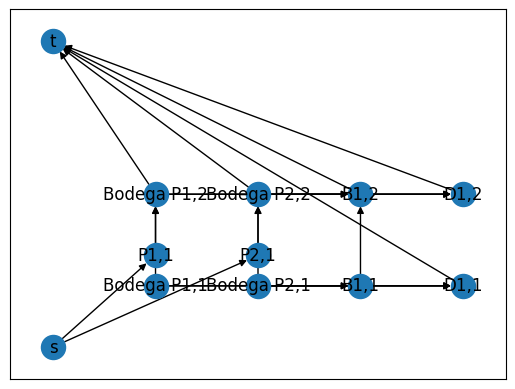

In [33]:
agr = []
for a in list(gvial.nodes()):
    if ',0' in a:
        agr.append(a)

agr1 = []
for a in list(gvial.edges()):
    if (',1' in a[0]) or (',1' in a[1]) or ('s' in a[0] or 's' in a[1]):
        agr1.append(a)
agr1
nx.draw_networkx(gvial, dddddd)
#nx.draw_networkx(gvial)
#arrows=True,

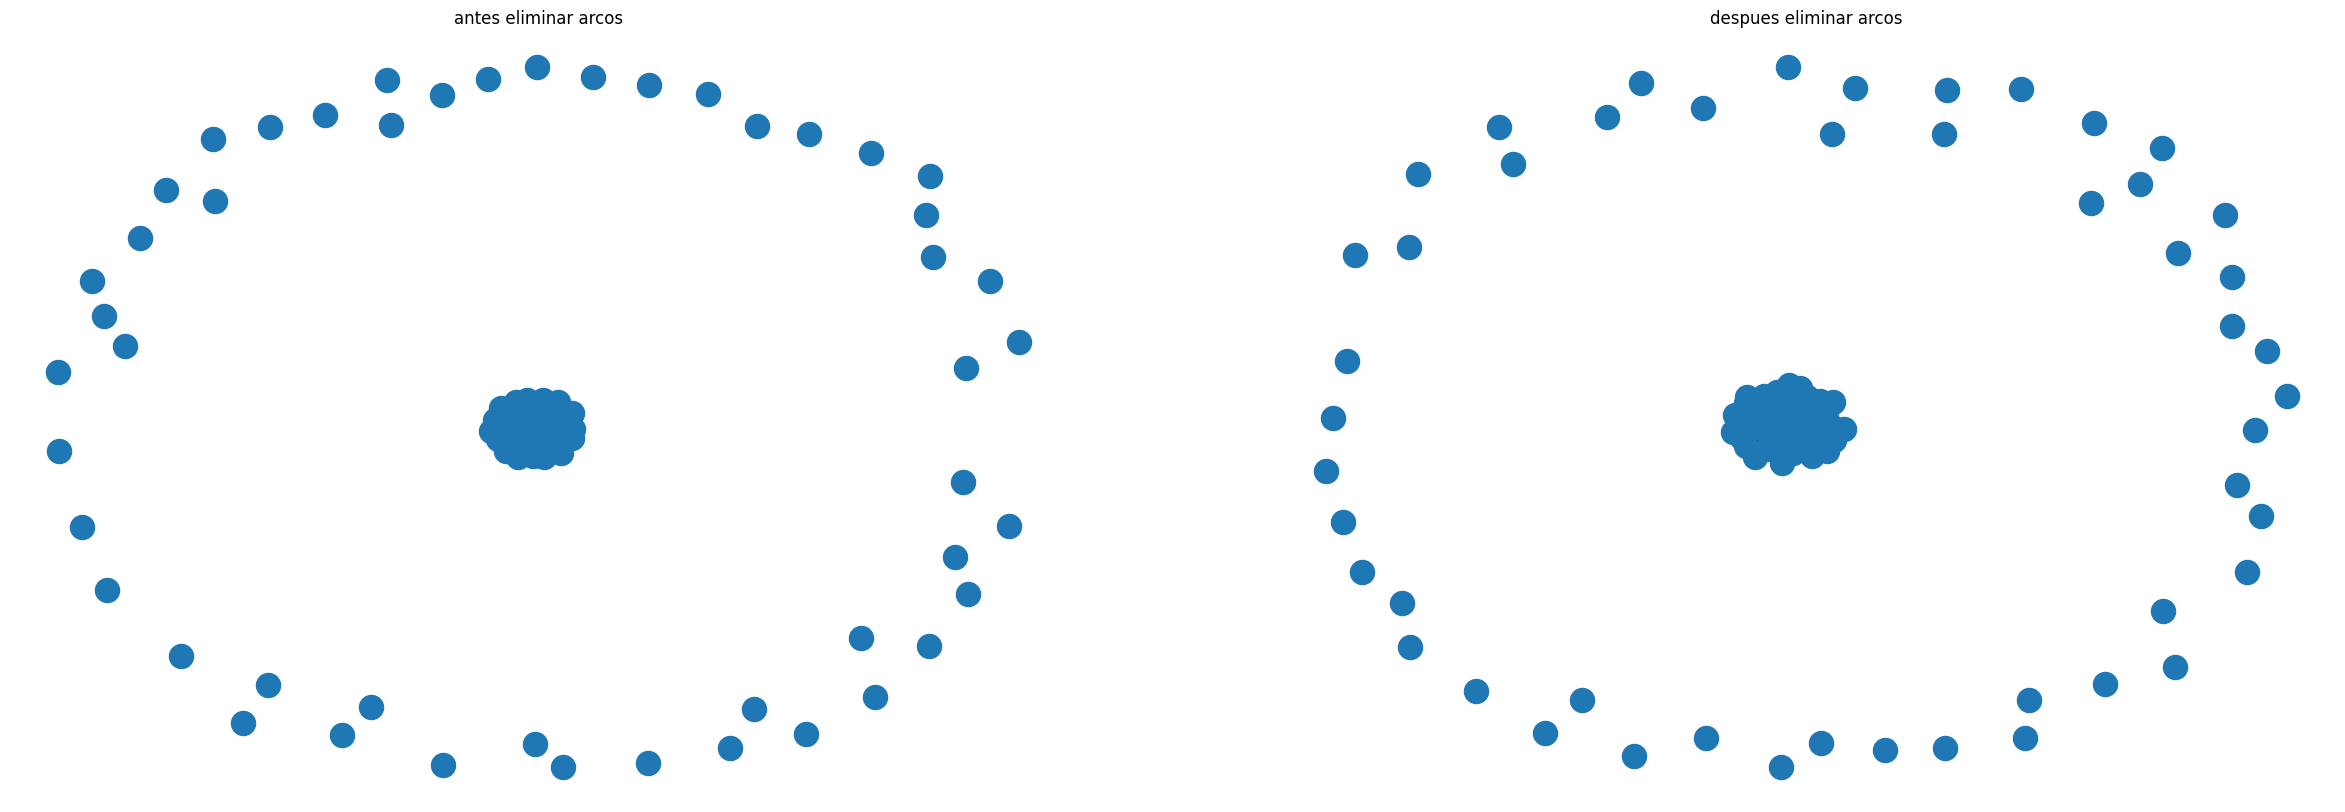

In [110]:
# OTROS:
    # CON ESTO PUEDO GRAFICAR PUERTO MONTT
'''ox.folium.plot_graph_folium(G0, tiles='CartoDB positron', color='red', weight=1)'''

    # esto lo encontre de casulidad, da los nodos adyacentes de otro nodo
#[(n, nbrdict) for n, nbrdict in G.adjacency()]
#print(nx.adjacency_matrix(grafo_vial_nuevo))

# ESTO ES SOLO PARA VER LOS ARCOS ELIMINADOS
plt.subplots(1,2, figsize = (30,10))

plt.subplot(1,2,1)
plt.title('antes eliminar arcos')
nx.draw(grafo_vial)

plt.subplot(1,2,2)
plt.title('despues eliminar arcos')
nx.draw(grafo_vial_nuevo)